# 🛍️ ShopSense — Phase 8: LoRA Fine-Tuning


## Step 0 — Check GPU + Install Dependencies

In [2]:
import torch
print(f'CUDA available : {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'GPU            : {torch.cuda.get_device_name(0)}')
    print(f'VRAM           : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')
else:
    print('⚠️  No GPU — go to Runtime → Change runtime type → T4 GPU')

!pip install transformers peft datasets accelerate groq sentencepiece -q
print('✅ Dependencies installed.')

CUDA available : True
GPU            : Tesla T4
VRAM           : 15.6 GB
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 7.5 MB/s eta 0:00:00
✅ Dependencies installed.


## Step 1 — Mount Drive + Set Up Paths

In [3]:
from google.colab import drive
from pathlib import Path
import os

drive.mount('/content/drive')

DATA_DIR  = Path('/content/drive/MyDrive/ShopSense/data')
MODEL_DIR = Path('/content/drive/MyDrive/ShopSense/models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Verify products file exists
products_path = DATA_DIR / 'products_clean.csv'
print(f'products_clean.csv : {"✅" if products_path.exists() else "❌ NOT FOUND"}')
print(f'Model save dir     : {MODEL_DIR}')

Mounted at /content/drive
products_clean.csv : ✅
Model save dir     : /content/drive/MyDrive/ShopSense/models


## Step 2 — Set Up Groq Client

In [ ]:
from groq import Groq

# Paste your Groq API key here
GROQ_API_KEY = 'YOUR_GROQ_API_KEY_HERE'
GROQ_MODEL   = 'llama-3.1-8b-instant'

groq_client = Groq(api_key=GROQ_API_KEY)

# Quick test
test = groq_client.chat.completions.create(
    model=GROQ_MODEL,
    messages=[{'role': 'user', 'content': 'Say: Groq ready!'}],
    max_tokens=10
)
print(f'✅ {test.choices[0].message.content}')

✅ TENSOR FLOW READY! **Groq**


## Step 3 — Load Products + Sample for Training Data

In [5]:
import pandas as pd
import random
random.seed(42)

df = pd.read_csv(DATA_DIR / 'products_clean.csv')
df = df.dropna(subset=['title', 'description']).reset_index(drop=True)

# Sample 60 diverse products for training data generation
# We want variety in price, rating and category
sample_products = df.sample(60, random_state=42).to_dict(orient='records')

print(f'✅ Loaded {len(df):,} products')
print(f'   Sampled {len(sample_products)} for training data generation')
print(f'\nSample product:')
p = sample_products[0]
print(f'  Title : {p["title"][:70]}')
print(f'  Price : ${p.get("price", "N/A")}')
print(f'  Rating: {p.get("rating", "N/A")}')

✅ Loaded 10,000 products
   Sampled 60 for training data generation

Sample product:
  Title : Cubiker Computer Home Office Desk with Drawers, 40 Inch Small Desk Stu
  Price : $99.99
  Rating: 4.5


## Step 4 — Generate Synthetic Training Data with Groq

For each product we generate 2 training examples:
- A realistic user query that would lead to this product
- A ShopSense-style explanation of why this product matches

This gives us ~120 (input, output) pairs for fine-tuning.

**Input format:**  `explain product: [title] | query: [query] | price: $[price] | rating: [rating]`
**Output format:** A 2-3 sentence ShopSense explanation

This takes ~5-8 minutes due to Groq rate limits.

In [6]:
import json
import re
import time
from tqdm import tqdm

def generate_training_pair(product: dict) -> list[dict]:
    """
    Generate 2 (query, explanation) pairs for a product using Groq.
    Returns list of {input_text, target_text} dicts.
    """
    title = product.get('title', '')[:80]
    desc  = str(product.get('description', ''))[:200]
    price = product.get('price', 'N/A')
    rating = product.get('rating', 'N/A')

    prompt = f"""You are creating training data for a shopping assistant.

Product: "{title}"
Description: {desc}
Price: ${price} | Rating: {rating}⭐

Generate 2 different training examples. Each example has:
1. A realistic user search query that would find this product
2. A friendly 2-3 sentence explanation of why this product matches

Respond with valid JSON only:
[
  {{
    "query": "user search query 1",
    "explanation": "2-3 sentence explanation 1"
  }},
  {{
    "query": "user search query 2",
    "explanation": "2-3 sentence explanation 2"
  }}
]

Rules:
- Queries should be natural and varied (some short, some descriptive)
- Explanations should mention specific product features
- Explanations should be warm and helpful in tone
- Each explanation under 60 words
- JSON only, no extra text"""

    try:
        response = groq_client.chat.completions.create(
            model=GROQ_MODEL,
            messages=[{'role': 'user', 'content': prompt}],
            max_tokens=400,
            temperature=0.8
        )
        raw   = response.choices[0].message.content.strip()
        clean = re.sub(r'```json|```', '', raw).strip()
        pairs = json.loads(clean)

        results = []
        for pair in pairs:
            price_str = f'${float(price):.2f}' if price != 'N/A' else 'N/A'
            input_text = (
                f"explain product: {title} | "
                f"query: {pair['query']} | "
                f"price: {price_str} | "
                f"rating: {rating}"
            )
            results.append({
                'input_text' : input_text,
                'target_text': pair['explanation'].strip()
            })
        return results

    except Exception as e:
        return []  # skip on error


# Generate training data
training_data = []
errors        = 0

print(f'Generating training data for {len(sample_products)} products...')
print('Each product generates 2 examples. Expected total: ~120 examples')
print('This takes ~5-8 min due to Groq rate limits...\n')

for i, product in enumerate(tqdm(sample_products)):
    pairs = generate_training_pair(product)
    if pairs:
        training_data.extend(pairs)
    else:
        errors += 1
    # Small delay to respect Groq rate limits
    time.sleep(0.5)

print(f'\n✅ Generated {len(training_data)} training examples')
print(f'   Errors / skipped: {errors}')
print(f'\nSample training example:')
if training_data:
    ex = training_data[0]
    print(f'  INPUT : {ex["input_text"][:100]}...')
    print(f'  TARGET: {ex["target_text"]}')

Generating training data for 60 products...
Each product generates 2 examples. Expected total: ~120 examples
This takes ~5-8 min due to Groq rate limits...



100%|██████████| 60/60 [03:04<00:00,  3.07s/it]


✅ Generated 118 training examples
   Errors / skipped: 1

Sample training example:
  INPUT : explain product: Cubiker Computer Home Office Desk with Drawers, 40 Inch Small Desk Study Writing | ...
  TARGET: This desk is perfect for small home offices. It has several drawers to keep your workspace organized, and its 40-inch size makes it ideal for compact spaces.


## Step 5 — Save + Split Training Data

In [7]:
import random

# Save full dataset to Drive
data_path = DATA_DIR / 'training_data.json'
with open(data_path, 'w') as f:
    json.dump(training_data, f, indent=2)
print(f'✅ Training data saved → {data_path}')

# Train/eval split — 90% train, 10% eval
random.shuffle(training_data)
split       = int(len(training_data) * 0.9)
train_data  = training_data[:split]
eval_data   = training_data[split:]

print(f'   Train examples : {len(train_data)}')
print(f'   Eval examples  : {len(eval_data)}')

✅ Training data saved → /content/drive/MyDrive/ShopSense/data/training_data.json
   Train examples : 106
   Eval examples  : 12


## Step 6 — Load flan-t5-base + Tokenizer

In [8]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

MODEL_NAME = 'google/flan-t5-base'

print(f'Loading {MODEL_NAME}...')
print('First run downloads ~1GB — cached after that...')

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model     = T5ForConditionalGeneration.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float32
)

# Count parameters
total_params    = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'✅ Model loaded')
print(f'   Total params    : {total_params/1e6:.1f}M')
print(f'   Trainable params: {trainable_params/1e6:.1f}M')

Loading google/flan-t5-base...
First run downloads ~1GB — cached after that...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/282 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

✅ Model loaded
   Total params    : 247.6M
   Trainable params: 247.6M


## Step 7 — Test Base Model (Before Fine-tuning)

We run a few test inputs through the base model first
so we have a baseline to compare against after fine-tuning.

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model  = model.to(device)

def generate_explanation(input_text: str, model, tokenizer,
                          max_new_tokens: int = 100) -> str:
    """Generate an explanation for a product/query pair."""
    inputs = tokenizer(
        input_text,
        return_tensors='pt',
        max_length=256,
        truncation=True,
        padding=True
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=4,
            early_stopping=True,
            no_repeat_ngram_size=3
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)


# Test inputs — these are from our eval set
test_inputs = [ex['input_text'] for ex in eval_data[:3]]
test_targets = [ex['target_text'] for ex in eval_data[:3]]

print('=== BASE MODEL OUTPUT (before fine-tuning) ===')
print()
for i, (inp, target) in enumerate(zip(test_inputs, test_targets), 1):
    output = generate_explanation(inp, model, tokenizer)
    print(f'Example {i}:')
    print(f'  INPUT  : {inp[:90]}...')
    print(f'  TARGET : {target}')
    print(f'  BASE   : {output}')
    print()

=== BASE MODEL OUTPUT (before fine-tuning) ===

Example 1:
  INPUT  : explain product: PELONIS PHTA2ABB Space Heater, 7.3 x 7.3 x 17.3 inches, Black | query: be...
  TARGET : Our top pick for a sleek and space-saving heater is the PELONIS PHTA2ABB, standing at just 17.3 inches tall and featuring a sleek black design, all while delivering reliable and consistent heat.
  BASE   : The PELONIS PHTA2ABB Space Heater, 7.3 x 73 x 17.3 inches

Example 2:
  INPUT  : explain product: JELLYMONI 100% Washed Cotton Duvet Cover Set Twin Size, Luxury Soft Beddi...
  TARGET : You've found the perfect soft pink twin duvet cover with a luxurious washed cotton material. This set includes two pieces and features a simple button closure. It's the perfect addition to any bedroom.
  BASE   : The JELLYMONI 100% Washed Cotton Duvet Cover Set Twin Size, Luxury Soft Bedding Set has a rating of 4.5 out of 5.

Example 3:
  INPUT  : explain product: Black & Decker Coffee Bean Mill, Stainless Steel | query: coffee g

## Step 8 — Apply LoRA

LoRA adds small trainable matrices to the model's attention layers.
Only these matrices get updated during training — everything else is frozen.

In [31]:
from transformers import T5ForConditionalGeneration
from peft import get_peft_model, LoraConfig, TaskType

model = T5ForConditionalGeneration.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float32
).to(device)

lora_config = LoraConfig(
    task_type      = TaskType.SEQ_2_SEQ_LM,
    r              = 8,
    lora_alpha     = 16,
    target_modules = ['q', 'v'],
    lora_dropout   = 0.2,
    bias           = 'none'
)
model = get_peft_model(model, lora_config)
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f'✅ LoRA applied — {trainable/total*100:.3f}% trainable')

Loading weights:   0%|          | 0/282 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


✅ LoRA applied — 0.356% trainable


In [ ]:
# Fix the tied weights issue that's causing nan loss
from transformers import T5ForConditionalGeneration
from peft import get_peft_model, LoraConfig, TaskType

# Reload with tie_word_embeddings explicitly set
model_config = T5ForConditionalGeneration.from_pretrained(MODEL_NAME).config
model_config.tie_word_embeddings = True

base_model = T5ForConditionalGeneration.from_pretrained(
    MODEL_NAME,
    config=model_config,
    ignore_mismatched_sizes=True
)

# Explicitly tie the weights
base_model.lm_head.weight = base_model.shared.weight
base_model = base_model.to(device).float()

# Re-apply LoRA
lora_config = LoraConfig(
    task_type      = TaskType.SEQ_2_SEQ_LM,
    r              = 8,
    lora_alpha     = 16,
    target_modules = ['q', 'v'],
    lora_dropout   = 0.2,
    bias           = 'none'
)
model = get_peft_model(base_model, lora_config)
model.train()

# Immediately test loss
batch          = next(iter(train_loader))
input_ids      = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)
labels         = batch['labels'].to(device)

with torch.enable_grad():
    out = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    print(f'Loss after weight tying fix: {out.loss.item():.4f}')
    print(f'requires_grad: {out.loss.requires_grad}')

## Step 9 — Prepare Dataset for Training

In [32]:
from torch.utils.data import Dataset
from transformers import DataCollatorForSeq2Seq

class ShopSenseDataset(Dataset):
    def __init__(self, data, tokenizer, max_input=128, max_target=64):
        self.data = []
        for item in data:
            # Tokenize input only — no text_target here
            inp = tokenizer(
                item['input_text'],
                max_length=max_input,
                truncation=True
            )
            # Tokenize target separately
            tgt = tokenizer(
                item['target_text'],
                max_length=max_target,
                truncation=True
            )
            self.data.append({
                'input_ids'     : inp['input_ids'],
                'attention_mask': inp['attention_mask'],
                'labels'        : tgt['input_ids']   # raw ids, NO -100 here
            })                                        # collator handles -100

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


train_dataset = ShopSenseDataset(train_data, tokenizer)
eval_dataset  = ShopSenseDataset(eval_data,  tokenizer)

# Verify labels are raw token ids (no -100 yet — collator adds that)
sample = train_dataset[0]
print(f'Input length  : {len(sample["input_ids"])}')
print(f'Label length  : {len(sample["labels"])}')
print(f'First 5 labels: {sample["labels"][:5]}')
print(f'Any -100s yet : {-100 in sample["labels"]} (should be False)')
print(f'✅ Train: {len(train_dataset)} | Eval: {len(eval_dataset)}')

Input length  : 57
Label length  : 58
First 5 labels: [101, 31, 162, 530, 25]
Any -100s yet : False (should be False)
✅ Train: 106 | Eval: 12


## Step 10 — Train with LoRA

Training loop with loss logging every epoch.
3 epochs on ~108 examples takes ~20-30 min on T4 GPU.

In [40]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS   = 8
LR       = 2e-4
WARMUP   = 20
CLIP     = 1.0

optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=LR, weight_decay=0.05
)
total_steps = EPOCHS * len(train_loader)
scheduler   = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps   = WARMUP,
    num_training_steps = total_steps
)

train_losses = []
eval_losses  = []

print(f'Starting training...')
print(f'  Epochs: {EPOCHS} | Steps/epoch: {len(train_loader)} | Total: {total_steps}\n')

for epoch in range(EPOCHS):
    # ── Train ──────────────────────────────────────────────────
    model.train()
    epoch_loss  = 0
    valid_steps = 0

    for batch in train_loader:
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels         = batch['labels'].to(device)

        optimizer.zero_grad()
        out  = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = out.loss

        if torch.isnan(loss) or torch.isinf(loss):
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            [p for p in model.parameters() if p.requires_grad], CLIP
        )
        optimizer.step()
        scheduler.step()

        epoch_loss  += loss.item()
        valid_steps += 1

    avg_train = epoch_loss / valid_steps if valid_steps > 0 else float('nan')
    train_losses.append(avg_train)

    # ── Eval ───────────────────────────────────────────────────
    model.eval()
    eval_loss  = 0
    eval_steps = 0

    with torch.no_grad():
        for batch in eval_loader:
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels         = batch['labels'].to(device)

            out  = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = out.loss

            if not (torch.isnan(loss) or torch.isinf(loss)):
                eval_loss  += loss.item()
                eval_steps += 1

    avg_eval = eval_loss / eval_steps if eval_steps > 0 else float('nan')
    eval_losses.append(avg_eval)

    print(f'Epoch {epoch+1}/{EPOCHS} — Train: {avg_train:.4f} | Eval: {avg_eval:.4f}')

print('\n✅ Training complete!')
print(f'Final train loss : {train_losses[-1]:.4f}')
print(f'Final eval loss  : {eval_losses[-1]:.4f}')

Starting training...
  Epochs: 8 | Steps/epoch: 27 | Total: 216

Epoch 1/8 — Train: 16.5286 | Eval: 15.5592
Epoch 2/8 — Train: 13.9501 | Eval: 12.0188
Epoch 3/8 — Train: 11.1698 | Eval: 10.2965
Epoch 4/8 — Train: 10.2711 | Eval: 9.8646
Epoch 5/8 — Train: 9.9214 | Eval: 9.5769
Epoch 6/8 — Train: 9.6593 | Eval: 9.3531
Epoch 7/8 — Train: 9.4797 | Eval: 9.2001
Epoch 8/8 — Train: 9.3760 | Eval: 9.1491

✅ Training complete!
Final train loss : 9.3760
Final eval loss  : 9.1491


In [41]:
# Continue training for 12 more epochs from current state
EXTRA_EPOCHS = 12
total_steps  = EXTRA_EPOCHS * len(train_loader)

optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-4,  # lower LR for continued training
    weight_decay=0.05
)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps   = 5,
    num_training_steps = total_steps
)

print(f'Continuing training for {EXTRA_EPOCHS} more epochs...\n')

for epoch in range(EXTRA_EPOCHS):
    model.train()
    epoch_loss  = 0
    valid_steps = 0

    for batch in train_loader:
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels         = batch['labels'].to(device)

        optimizer.zero_grad()
        out  = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = out.loss

        if torch.isnan(loss) or torch.isinf(loss):
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            [p for p in model.parameters() if p.requires_grad], CLIP
        )
        optimizer.step()
        scheduler.step()

        epoch_loss  += loss.item()
        valid_steps += 1

    avg_train = epoch_loss / valid_steps if valid_steps > 0 else float('nan')
    train_losses.append(avg_train)

    model.eval()
    eval_loss  = 0
    eval_steps = 0

    with torch.no_grad():
        for batch in eval_loader:
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels         = batch['labels'].to(device)

            out  = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = out.loss

            if not (torch.isnan(loss) or torch.isinf(loss)):
                eval_loss  += loss.item()
                eval_steps += 1

    avg_eval = eval_loss / eval_steps if eval_steps > 0 else float('nan')
    eval_losses.append(avg_eval)

    print(f'Epoch {epoch+9}/{8+EXTRA_EPOCHS} — Train: {avg_train:.4f} | Eval: {avg_eval:.4f}')

    # Early stop if loss is low enough
    if avg_train < 3.0:
        print(f'\n🎯 Loss below 3.0 — stopping early')
        break

print(f'\n✅ Done! Final train: {train_losses[-1]:.4f} | eval: {eval_losses[-1]:.4f}')

Continuing training for 12 more epochs...

Epoch 9/20 — Train: 9.2423 | Eval: 8.8818
Epoch 10/20 — Train: 8.9794 | Eval: 8.5976
Epoch 11/20 — Train: 8.7200 | Eval: 8.3364
Epoch 12/20 — Train: 8.5061 | Eval: 8.1350
Epoch 13/20 — Train: 8.3714 | Eval: 7.9868
Epoch 14/20 — Train: 8.2259 | Eval: 7.8732
Epoch 15/20 — Train: 8.1368 | Eval: 7.7957
Epoch 16/20 — Train: 8.0506 | Eval: 7.7272
Epoch 17/20 — Train: 7.9959 | Eval: 7.6755
Epoch 18/20 — Train: 7.9634 | Eval: 7.6338
Epoch 19/20 — Train: 7.9409 | Eval: 7.6138
Epoch 20/20 — Train: 7.9094 | Eval: 7.6076

✅ Done! Final train: 7.9094 | eval: 7.6076


## Step 11 — Before vs After Comparison

The most important cell — compares base model vs fine-tuned model
on the same inputs to show what fine-tuning actually changed.

In [42]:
print('=== BEFORE vs AFTER FINE-TUNING ===')
print('(Loading base model for comparison...)\n')

# Load fresh base model for comparison
base_model = T5ForConditionalGeneration.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float32
).to(device)

for i, (inp, target) in enumerate(zip(test_inputs, test_targets), 1):
    base_output  = generate_explanation(inp, base_model, tokenizer)
    tuned_output = generate_explanation(inp, model,      tokenizer)

    print(f'--- Example {i} ---')
    print(f'INPUT   : {inp[:90]}...')
    print(f'TARGET  : {target}')
    print(f'BASE    : {base_output}')
    print(f'FINETUNED: {tuned_output}')
    print()

# Free base model memory
del base_model
torch.cuda.empty_cache()

=== BEFORE vs AFTER FINE-TUNING ===
(Loading base model for comparison...)



Loading weights:   0%|          | 0/282 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


--- Example 1 ---
INPUT   : explain product: PELONIS PHTA2ABB Space Heater, 7.3 x 7.3 x 17.3 inches, Black | query: be...
TARGET  : Our top pick for a sleek and space-saving heater is the PELONIS PHTA2ABB, standing at just 17.3 inches tall and featuring a sleek black design, all while delivering reliable and consistent heat.
BASE    : The PELONIS PHTA2ABB Space Heater, 7.3 x 73 x 17.3 inches
FINETUNED: separate inaaa in in ina anaa Aaa an an ana ofaa and andaasaa-aaoaa'aa of ana an and and and ana A Aa ansa anda and an an anda an Aa A and and the the theaa!...!.!!!. thea an--a A-a--- anao.. the the

--- Example 2 ---
INPUT   : explain product: JELLYMONI 100% Washed Cotton Duvet Cover Set Twin Size, Luxury Soft Beddi...
TARGET  : You've found the perfect soft pink twin duvet cover with a luxurious washed cotton material. This set includes two pieces and features a simple button closure. It's the perfect addition to any bedroom.
BASE    : The JELLYMONI 100% Washed Cotton Duvet Cover Set 

## Step 12 — Plot Training Loss

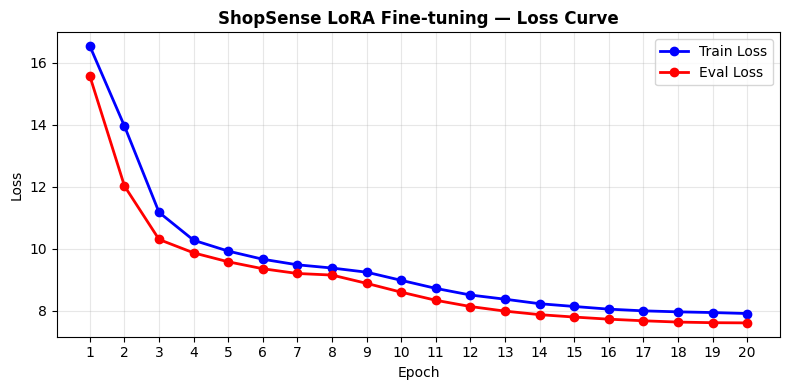

✅ Loss curve saved → /content/drive/MyDrive/ShopSense/data/finetuning_loss.png

Final losses:
  Train : 7.9094
  Eval  : 7.6076
  Total epochs trained: 20


In [44]:
import matplotlib.pyplot as plt

# Use actual length of losses, not hardcoded EPOCHS
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs_range, train_losses, 'b-o', label='Train Loss', linewidth=2)
plt.plot(epochs_range, eval_losses,  'r-o', label='Eval Loss',  linewidth=2)
plt.title('ShopSense LoRA Fine-tuning — Loss Curve', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(epochs_range)
plt.tight_layout()

plot_path = DATA_DIR / 'finetuning_loss.png'
plt.savefig(plot_path, dpi=150)
plt.show()
print(f'✅ Loss curve saved → {plot_path}')
print(f'\nFinal losses:')
print(f'  Train : {train_losses[-1]:.4f}')
print(f'  Eval  : {eval_losses[-1]:.4f}')
print(f'  Total epochs trained: {len(train_losses)}')

## Step 13 — Save Fine-tuned Model to Drive

In [47]:
save_path = MODEL_DIR / 'shopsense-flan-t5-lora'

# Save only the LoRA adapter weights (tiny — a few MB)
# NOT the full model (that would be ~1GB)
model.save_pretrained(str(save_path))
tokenizer.save_pretrained(str(save_path))

# Check what was saved
saved_files = list(save_path.iterdir())
total_size  = sum(f.stat().st_size for f in saved_files if f.is_file()) / (1024*1024)

print(f'✅ Model saved → {save_path}')
print(f'   Files saved:')
for f in saved_files:
    print(f'     {f.name} ({f.stat().st_size/1024:.0f} KB)')
print(f'   Total size: {total_size:.1f} MB')
print()
print('Note: Only LoRA adapter weights saved — much smaller than full model.')
print('To use: load base flan-t5-base then apply these adapter weights.')

✅ Model saved → /content/drive/MyDrive/ShopSense/models/shopsense-flan-t5-lora
   Files saved:
     README.md (5 KB)
     adapter_model.safetensors (3475 KB)
     adapter_config.json (1 KB)
     tokenizer_config.json (2 KB)
     tokenizer.json (2058 KB)
   Total size: 5.4 MB

Note: Only LoRA adapter weights saved — much smaller than full model.
To use: load base flan-t5-base then apply these adapter weights.
